In [3]:
import torch
from mlp import make_dataset, CharacterLevelMLP, Linear, BatchNormalization1D, Tanh
import matplotlib.pyplot as plt
from torch.optim import Adam
from pathlib import Path
from torch.nn.functional import cross_entropy
from sklearn.model_selection import train_test_split
%matplotlib inline

In [17]:
from PIL import Image

ASSETS = Path("assets")
OUT_DIR = Path("artifacts")
OUT_DIR.mkdir(parents=True, exist_ok=True)

images = [
    ASSETS / "raw_tensors.png",
    ASSETS / "custom_layers.png",
    ASSETS / "parameter_usage.png",
]

# Load images (skip missing and notify)
imgs = []
for p in images:
    if p.exists():
        imgs.append(Image.open(p).convert("RGBA"))
    else:
        print(f"Warning: missing {p}, skipping")

if not imgs:
    raise FileNotFoundError(f"No images found under {ASSETS}")

# Normalize width to max width, keep aspect ratio
max_w = max(im.width for im in imgs)
resized = []
for im in imgs:
    if im.width != max_w:
        new_h = int(im.height * (max_w / im.width))
        im = im.resize((max_w, new_h), Image.LANCZOS)
    resized.append(im)

# Stack vertically with padding
padding = 10
total_h = sum(im.height for im in resized) + padding * (len(resized) - 1)
canvas = Image.new("RGBA", (max_w, total_h), (255, 255, 255, 255))

y = 0
for im in resized:
    canvas.paste(im, (0, y), im)
    y += im.height + padding

out_path = OUT_DIR / "training_portrait.jpg"
canvas.convert("RGB").save(out_path, quality=95)
print(f"Saved portrait image to: {out_path}")

Saved portrait image to: artifacts\training_portrait.jpg


In [4]:
names_file = Path("./names.txt")
context_window = 3
X , Y, itos = make_dataset(names_file, context_window=context_window)

In [5]:
train_X, eval_X, train_Y, eval_Y = train_test_split(X,Y,test_size=0.2)

In [6]:
val_X, test_X, val_Y, test_Y = train_test_split(eval_X,eval_Y,test_size=0.5)

In [7]:
EPOCHS = 1000
batch_size=32
block_size=context_window
lre = torch.linspace(-3, 0, EPOCHS)
lrn = 10**lre
LEARNING_RATE = 0.1520

In [8]:
n_embedding = 10
n_hidden = 200
vocab_size = 27

## Neural Nets
* You must run only one

In [31]:
C = torch.randn((vocab_size, n_embedding))
W1 = torch.randn((n_embedding*block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size))
b2 = torch.randn(vocab_size)

batch_normalization_gain = torch.ones((1,n_hidden))
batch_normalization_bias = torch.ones((1,n_hidden))

parameters = [C,W1,b1,W2,b2]

train_steps = []
losses = []

eval_steps = []
eval_losses = []

for i in range(EPOCHS):
    
    for p in parameters:
        p.requires_grad = True
        
    # Minibatch sampling
    random_index = torch.randint(0,train_X.shape[0],(batch_size,))
    
    X_batch = train_X[random_index]
    Y_batch = train_Y[random_index]
    
    embeddings = C[X_batch]
    hidden_dim = embeddings.view((embeddings.shape[0], -1)) @ W1 + b1
    hidden_dim = batch_normalization_gain* (hidden_dim - hidden_dim.mean(0,keepdim=True))/hidden_dim.std(0,keepdim=True) + batch_normalization_bias
    hidden_dim = torch.tanh(hidden_dim)
    logits = hidden_dim @ W2 + b2
    
    loss = cross_entropy(logits, Y_batch)
    losses.append(loss.item())
    train_steps.append(i)
        
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # learning_rate = lrn[i]
    for p in parameters:
        p.data += -LEARNING_RATE * p.grad
        
    
    if i%10 == 0:
        # Disable params grads
        for p in parameters:
            p.requires_grad = False
        
        embeddings = C[val_X]
        hidden_dim = embeddings.view((embeddings.shape[0], -1)) @ W1 + b1
        hidden_dim = batch_normalization_gain* (hidden_dim - hidden_dim.mean(0,keepdim=True))/hidden_dim.std(0,keepdim=True) + batch_normalization_bias
        hidden_dim = torch.tanh(hidden_dim)
        logits = hidden_dim @ W2 + b2
        
        loss = cross_entropy(logits, val_Y)
        eval_losses.append(loss.item())
        eval_steps.append(i)

In [10]:
C = torch.randn((vocab_size, n_embedding))
layers = [
    Linear(n_embedding*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(), BatchNormalization1D(n_hidden),
    Linear(n_hidden, n_hidden), Tanh(), BatchNormalization1D(n_hidden),
    Linear(n_hidden, n_hidden), Tanh(), BatchNormalization1D(n_hidden),
    Linear(n_hidden, vocab_size)
]

layers[-1].weights *= 0.1
for layer in layers:
    if isinstance(layer, Linear):
        layer.weights *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]

train_steps = []
losses = []

eval_steps = []
eval_losses = []

for i in range(EPOCHS):
    
    for p in parameters:
        p.requires_grad = True
        
    # Minibatch sampling
    random_index = torch.randint(0,train_X.shape[0],(batch_size,))
    
    X_batch = train_X[random_index]
    Y_batch = train_Y[random_index]
    
    embeddings = C[X_batch]
    x = embeddings.view(embeddings.shape[0],-1)
    for layer in layers:
        x = layer(x)
    logits = x
    
    loss = cross_entropy(logits, Y_batch)
    losses.append(loss.item())
    train_steps.append(i)
        
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # learning_rate = lrn[i]
    for p in parameters:
        p.data += -LEARNING_RATE * p.grad
        
    if i%10 == 0:
        # Disable params grads
        for p in parameters:
            p.requires_grad = False
        
        embeddings = C[val_X]
        x = embeddings.view(embeddings.shape[0],-1)
        for layer in layers:
            x = layer(x)
        logits = x
        
        loss = cross_entropy(logits, val_Y)
        eval_losses.append(loss.item())
        eval_steps.append(i)

In [12]:
mlp_network = CharacterLevelMLP(vocab_size, n_embedding, n_hidden, context_window)
adam = Adam(mlp_network.parameters(), lr=LEARNING_RATE)

train_steps = []
losses = []

eval_steps = []
eval_losses = []

for i in range(EPOCHS):
    
    # Minibatch sampling
    random_index = torch.randint(0,train_X.shape[0],(batch_size,))
    
    X_batch = train_X[random_index]
    Y_batch = train_Y[random_index]
    
    mlp_network.train()
    logits = mlp_network(X_batch)
    
    loss = cross_entropy(logits, Y_batch)
    losses.append(loss.item())
    train_steps.append(i)

    # Clear gradients from previous iteration
    adam.zero_grad()
        
    loss.backward()
    
    # Update parameters
    adam.step()
    
    if i%10 == 0:
        
        mlp_network.eval()
        logits = mlp_network(val_X)
        
        loss = cross_entropy(logits, val_Y)
        eval_losses.append(loss.item())
        eval_steps.append(i)

## Plot results

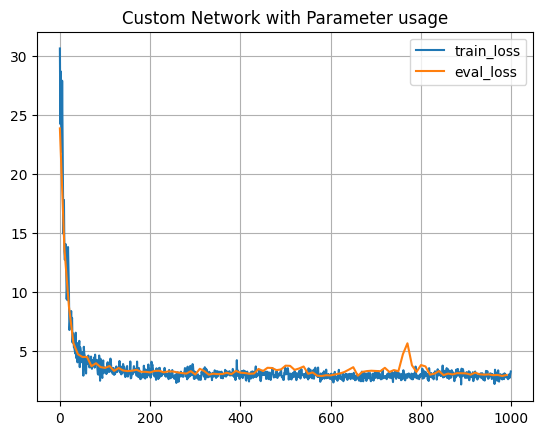

In [13]:
plt.title("Custom Network with Parameter usage")
plt.grid()
plt.plot(losses, label="train_loss")
plt.plot(eval_steps,eval_losses, label="eval_loss")
plt.legend()

Text(0.5, 1.0, 'Activations Distribution')

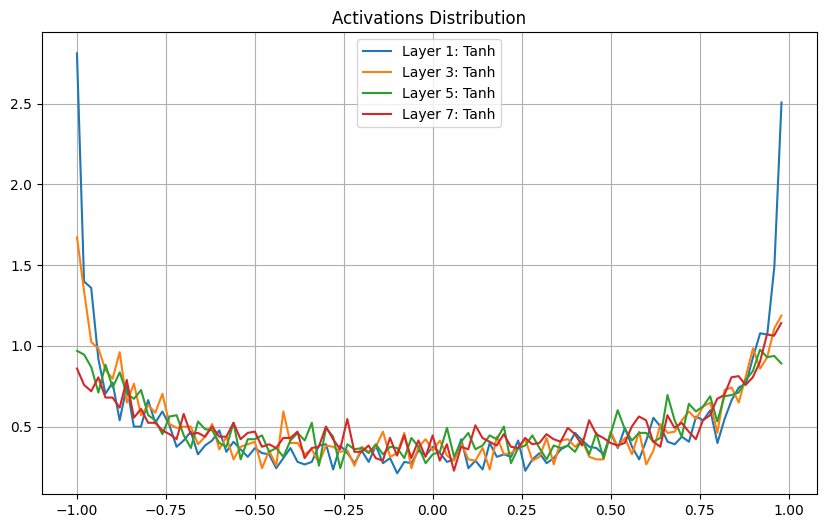

In [30]:
legends = []
plt.figure(figsize=(10,6))
plt.grid()
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i}: {layer.__class__.__name__}")
plt.legend(legends)
plt.title("Activations Distribution")